## **Dogs vs Cats Classifier Model 1**

Original classifier, but made changes to the image size (200 x 200) and batch size (30). These are the only differences betweent this notebook and `dog-cat-classifier.ipynb`.

**Results:** 92% accuracy.


There was marginal improvement in comparison to the original model (e.g. 2% increase in accuracy), which I don't believe warrants using this model over the original.

In [1]:
# Clone repository
# Loads Kaggle dataset into local storage
# Idea from this link: https://medium.com/@yuraist/how-to-upload-your-own-dataset-into-google-colab-e228727c87e9
! git clone https://github.com/tlapinsk/colab-examples.git

Cloning into 'colab-examples'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 37440 (delta 11), reused 28 (delta 7), pack-reused 37407
Receiving objects: 100% (37440/37440), 811.56 MiB | 15.18 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Checking out files: 100% (37507/37507), done.


In [2]:
! ls

colab-examples	sample_data


In [3]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("colab-examples/data/dogs-vs-cats/"))

Using TensorFlow backend.


['train', 'test', '.DS_Store']


In [0]:
# Set some variables
IMAGE_WIDTH    = 200
IMAGE_HEIGHT   = 200
IMAGE_SIZE     = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [5]:
# Split into dog versus cat categories (0, 1)
filenames = os.listdir("colab-examples/data/dogs-vs-cats/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

# Preview changes
df.head()

,filename,category
0,dog.8137.jpg,1
1,dog.5632.jpg,1
2,cat.1729.jpg,0
3,dog.7131.jpg,1
4,dog.10187.jpg,1


In [6]:
# Preview changes
df.tail()

,filename,category
24995,cat.11844.jpg,0
24996,dog.12328.jpg,1
24997,cat.6646.jpg,0
24998,cat.11407.jpg,0
24999,dog.3463.jpg,1


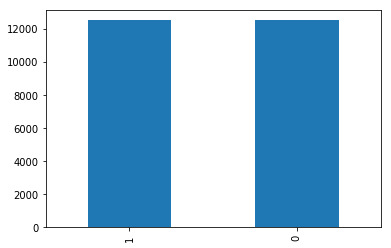

In [7]:
# Check out totals in a bar graph
df['category'].value_counts().plot.bar()

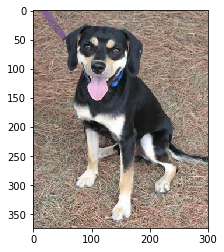

In [8]:
# Random sample image
sample = random.choice(filenames)
image = load_img("colab-examples/data/dogs-vs-cats/train/"+sample)
plt.imshow(image)

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

# Build Keras model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# View summary of model
model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 198, 198, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 97, 97, 64)        25

In [0]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Stop training when a monitored quantity has stopped improving
# https://keras.io/callbacks/#earlystopping
earlystop = EarlyStopping(patience=10)

# Reduce learning rate when metric has stopped improving
# https://keras.io/callbacks/#reducelronplateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

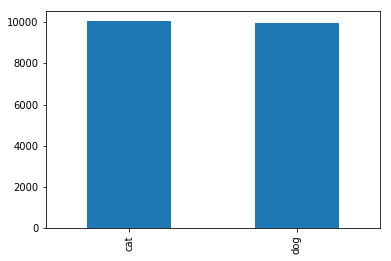

In [11]:
# Split training and validation sets
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

# View training count for cats and dogs. 10,000 each
train_df['category'].value_counts().plot.bar()

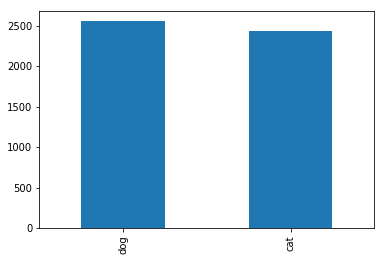

In [12]:
# View validation set. 2,500 each
validate_df['category'].value_counts().plot.bar()

In [0]:
total_train    = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size     = 30
epochs         = 50

In [14]:
# Build training generator
# Real-time data augmentation
# https://keras.io/preprocessing/image/
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "colab-examples/data/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [15]:
# Build validation generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "colab-examples/data/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [16]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "colab-examples/data/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


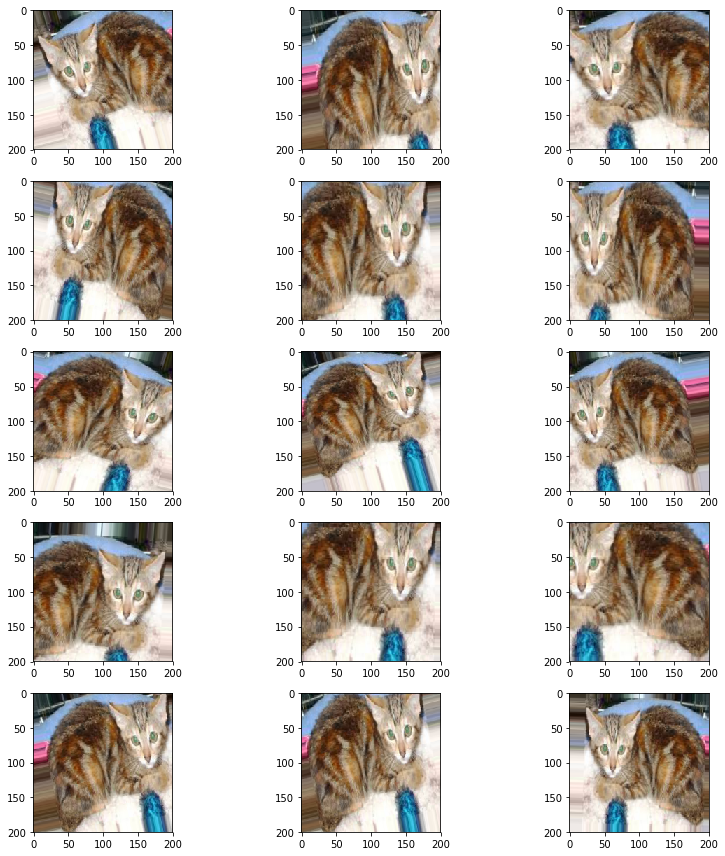

In [17]:
# Sample data augmentation
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [18]:
# Train model
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
666/666 [==============================] - 286s 430ms/step - loss: 0.7638 - acc: 0.6363 - val_loss: 0.6580 - val_acc: 0.6450
Epoch 2/50
666/666 [==============================] - 284s 426ms/step - loss: 0.5304 - acc: 0.7351 - val_loss: 0.6037 - val_acc: 0.7078
Epoch 3/50
666/666 [==============================] - 284s 427ms/step - loss: 0.4741 - acc: 0.7778 - val_loss: 0.5123 - val_acc: 0.7829
Epoch 4/50
666/666 [==============================] - 284s 426ms/step - loss: 0.4390 - acc: 0.8003 - val_loss: 0.4736 - val_acc: 0.8060
Epoch 5/50
666/666 [==============================] - 283s 425ms/step - loss: 0.4086 - acc: 0.8179 - val_loss: 0.4374 - val_acc: 0.7992
Epoch 6/50
666/666 [==============================] - 282s 423ms/step - loss: 0.3863 - acc: 0.8292 - val_loss: 3.0113 - val_acc: 0.5742

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7

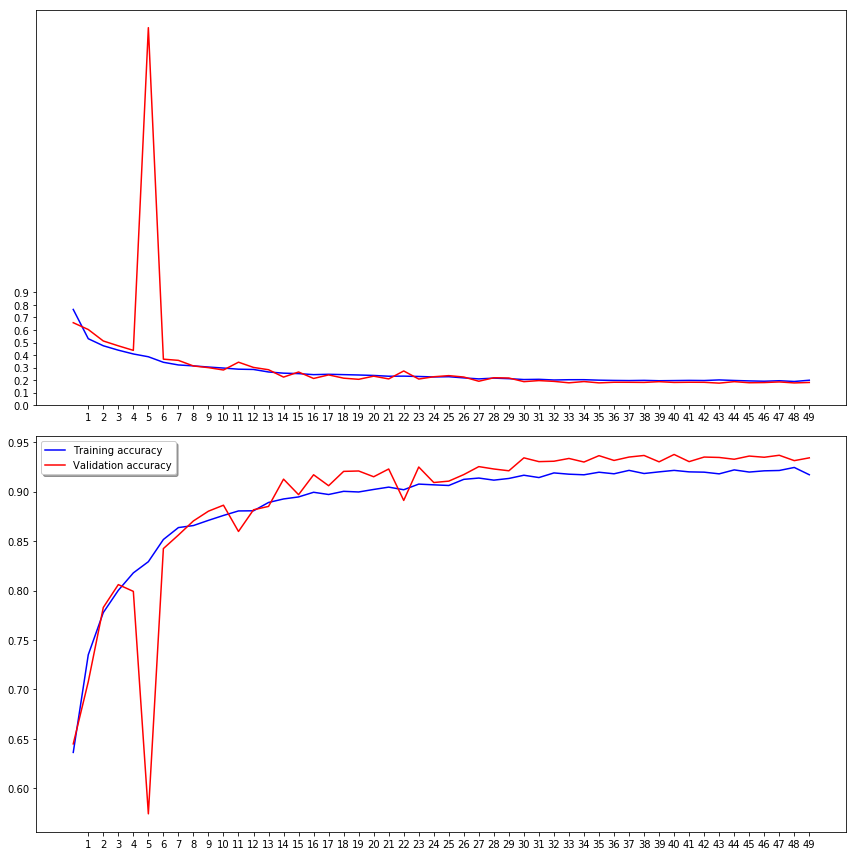

In [19]:
# Plot loss and accuracy over 50 epochs
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()